In [1]:
# 📚 Intent Diet Change - Full Regression Pipeline (with Enhancements)

# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import shap
import warnings
import time
import scipy

warnings.filterwarnings('ignore')

In [3]:
# 📂 Upload directly from your device
from google.colab import files
uploaded = files.upload()

Saving Data of 300 people v2.xlsx to Data of 300 people v2.xlsx


In [4]:
# ⏳ Step 2: Load Dataset
start_time = time.time()
df = pd.read_excel("Data of 300 people v2.xlsx")

# 🔍 Step 3: Initial Exploration
print("Data Shape:", df.shape)
df.info()
print("Missing Values:\n", df.isnull().sum())
print(df.describe())
df.head()

Data Shape: (315, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   family_diabetes                 315 non-null    object
 1   fantasy_no_control              315 non-null    int64 
 2   fantasy_magic_cure              315 non-null    int64 
 3   fantasy_no_healthy_habits       315 non-null    int64 
 4   fantasy_no_exercise             315 non-null    int64 
 5   aware_high_risk                 315 non-null    int64 
 6   aware_family_problem            315 non-null    int64 
 7   aware_other_diseases            315 non-null    int64 
 8   aware_health_consequence        315 non-null    int64 
 9   aware_need_exercise             315 non-null    int64 
 10  aware_need_meds_diet            315 non-null    int64 
 11  risk_no_diet_exercise           315 non-null    int64 
 12  future_risk_no_control      

,family_diabetes,fantasy_no_control,fantasy_magic_cure,fantasy_no_healthy_habits,fantasy_no_exercise,aware_high_risk,aware_family_problem,aware_other_diseases,aware_health_consequence,aware_need_exercise,...,intent_diet_change,predict_lifestyle_change,consistency_lifestyle_change,gender,age,marital_status,education,profession,diabetes_status,daily_exercise
0,Yes,2,2,1,1,6,5,5,5,5,...,7,6,6,Female,21-25 years,Married,Honors or equivalent,Student,More than 4 years,Less than 10 minutes
1,Yes,2,2,2,3,6,6,7,7,7,...,6,7,6,Male,21-25 years,Married,PhD or equivalent,Student,2-4 years,Less than 10 minutes
2,Yes,1,1,2,2,5,6,6,5,6,...,6,6,6,Female,36-40 years,Married,No recognized academic degree,Others,More than 4 years,10 to 20 minutes
3,Yes,2,2,3,1,5,5,6,6,6,...,6,6,6,Male,56-60 years,Married,SSC or equivalent,Business,2-4 years,10 to 20 minutes
4,Yes,2,1,3,1,6,5,5,6,5,...,6,7,6,Male,61-65 years,Married,Diploma or equivalent,Others,More than 4 years,Less than 10 minutes


In [5]:
# 🧼 Step 4: Handle Missing Values
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=np.number).columns

num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

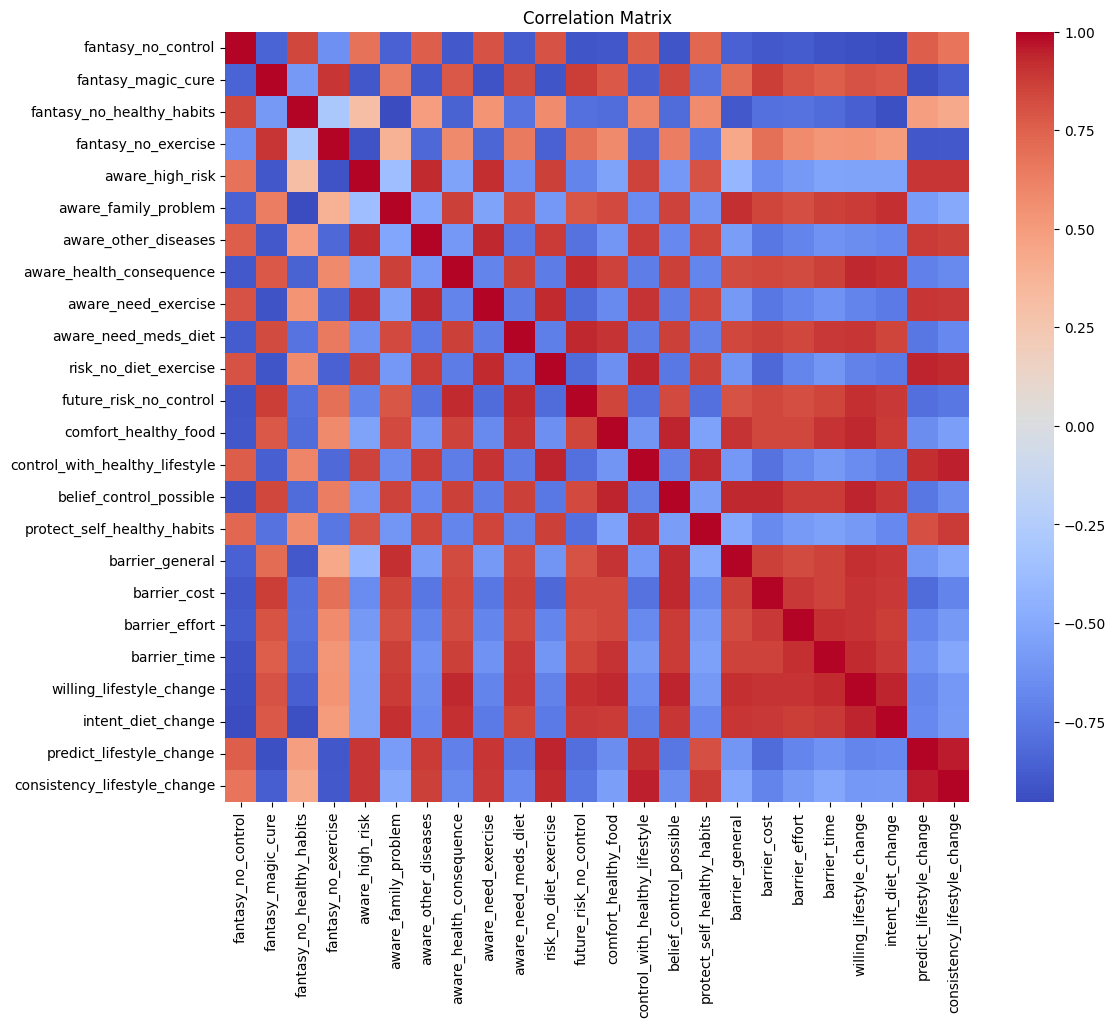

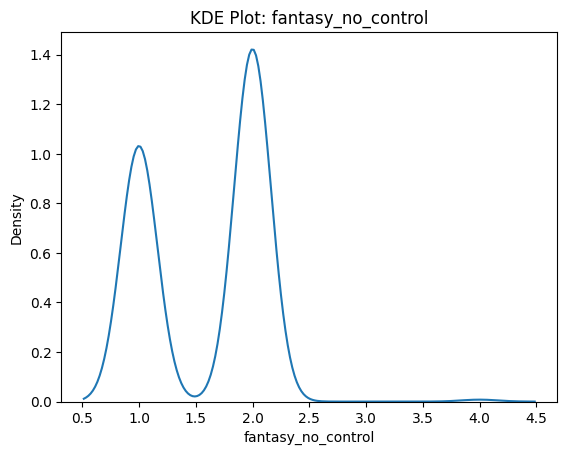

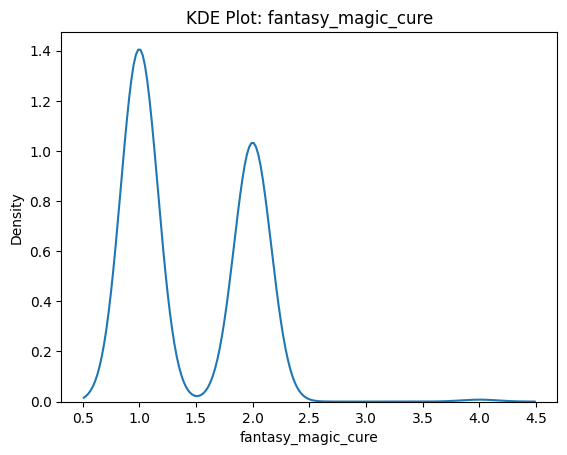

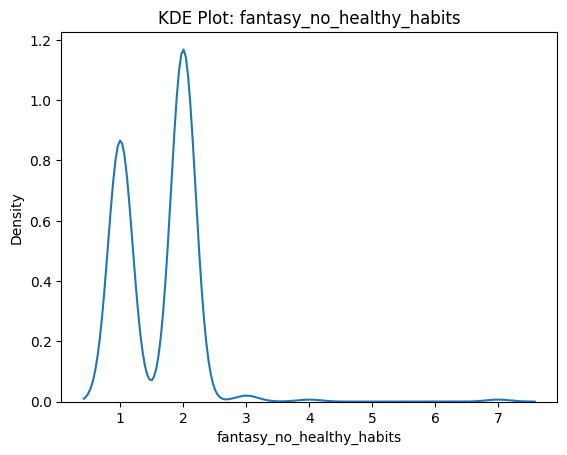

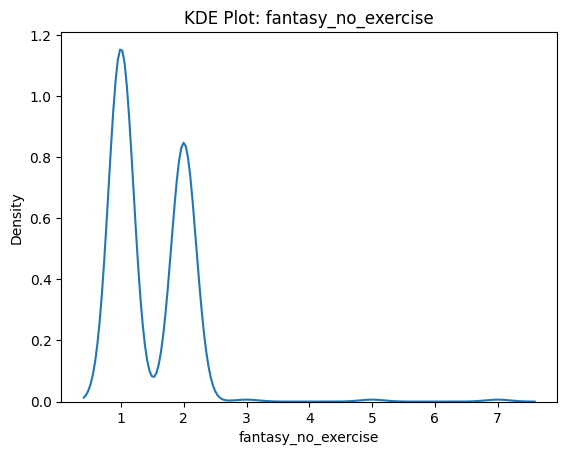

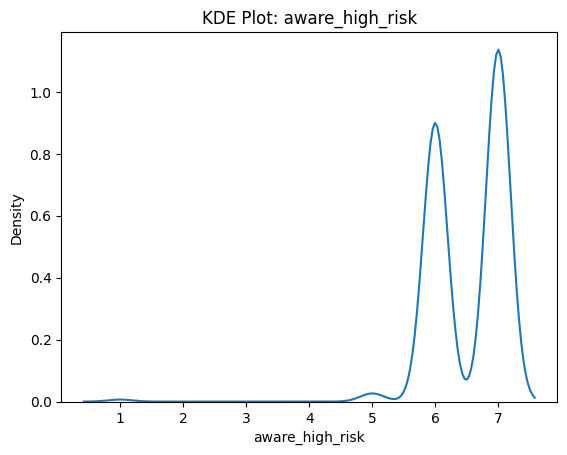

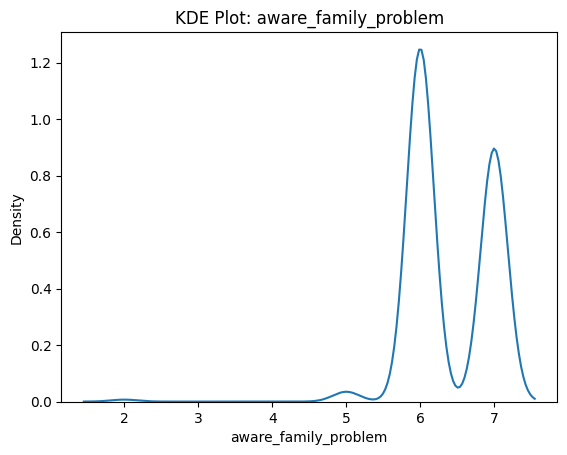

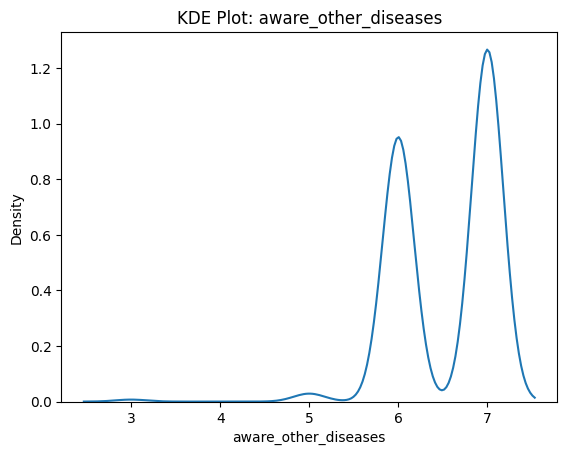

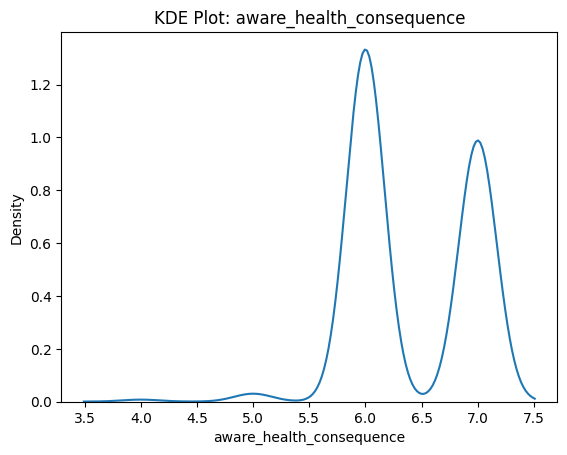

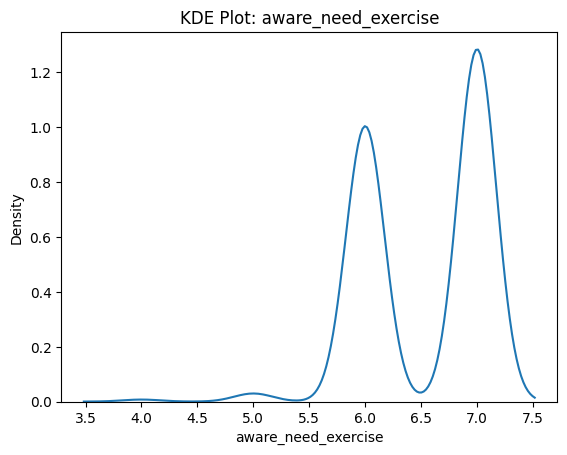

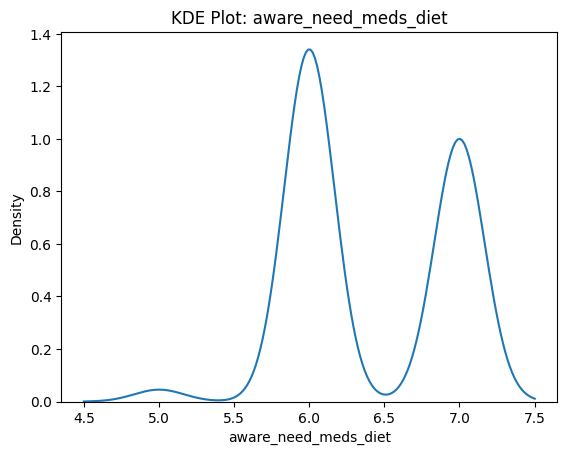

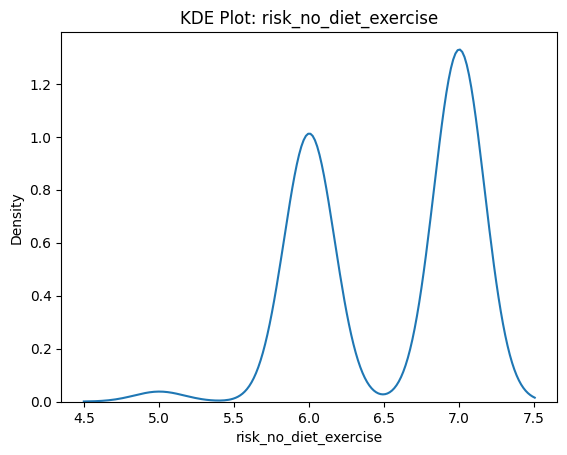

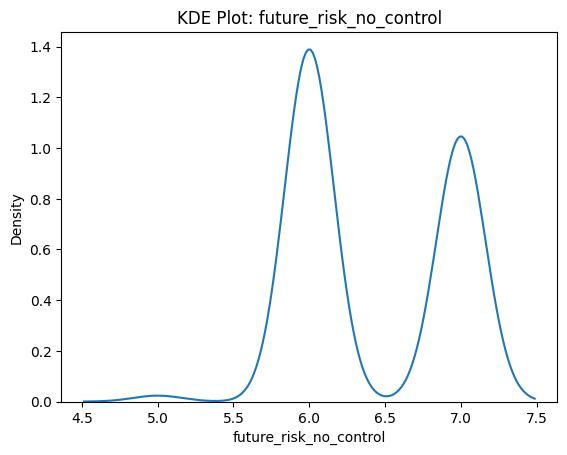

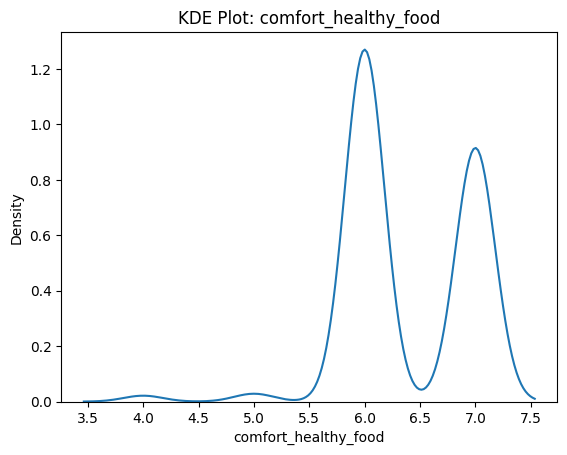

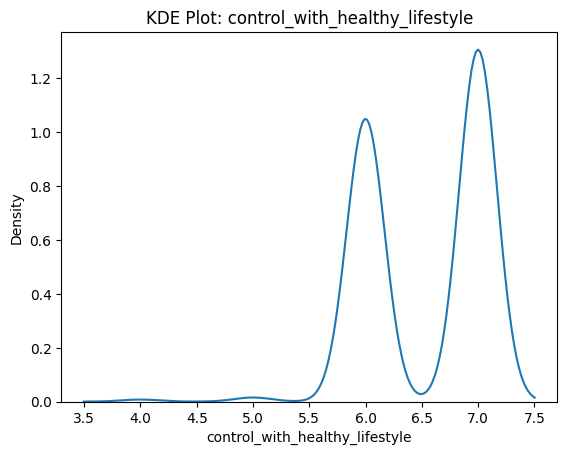

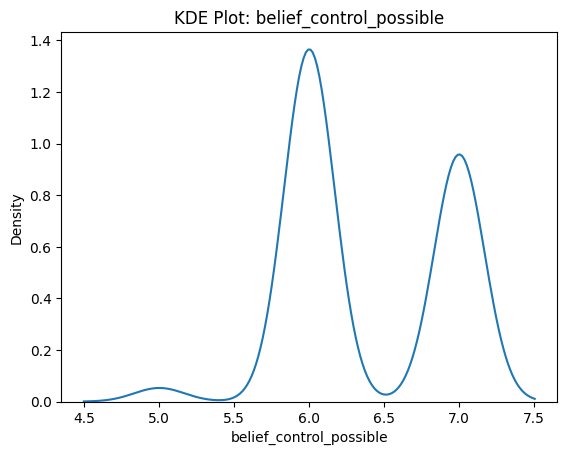

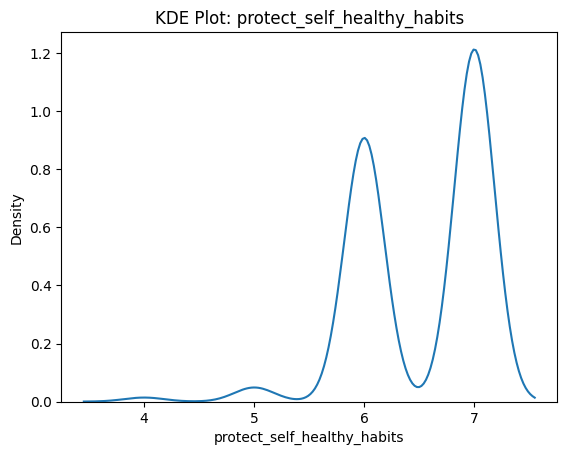

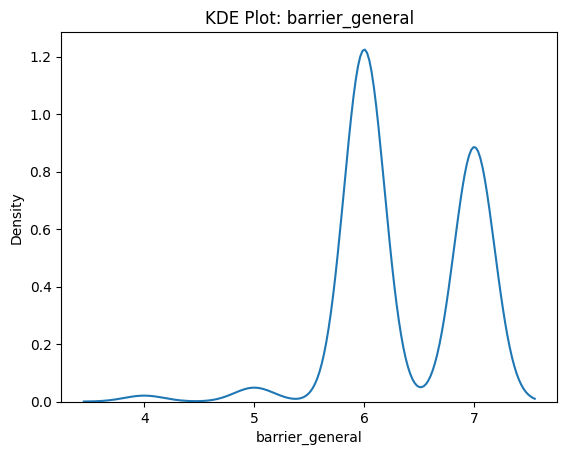

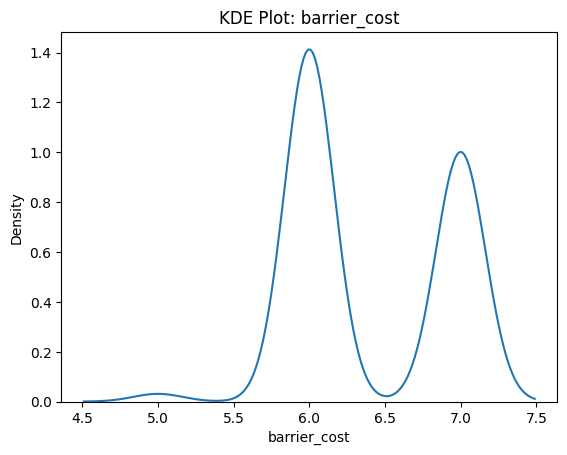

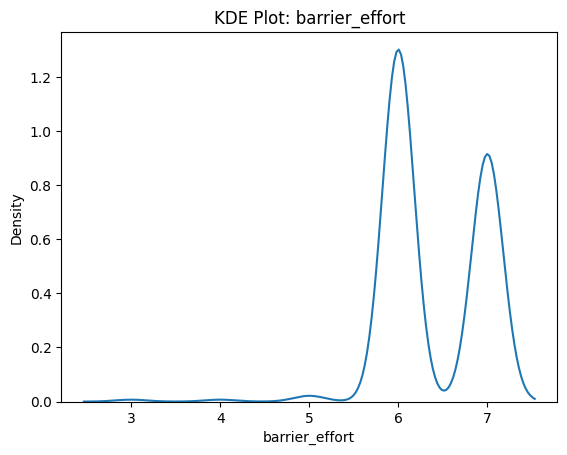

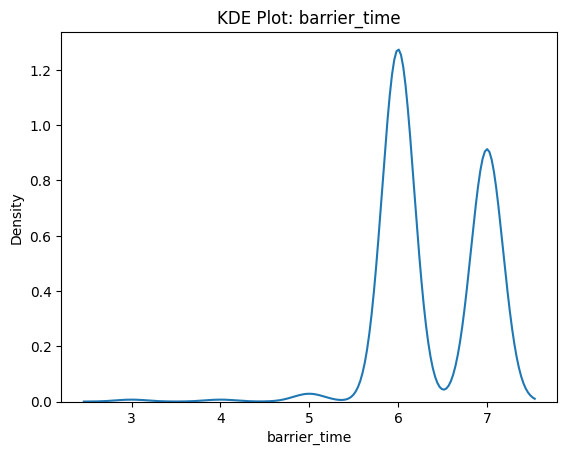

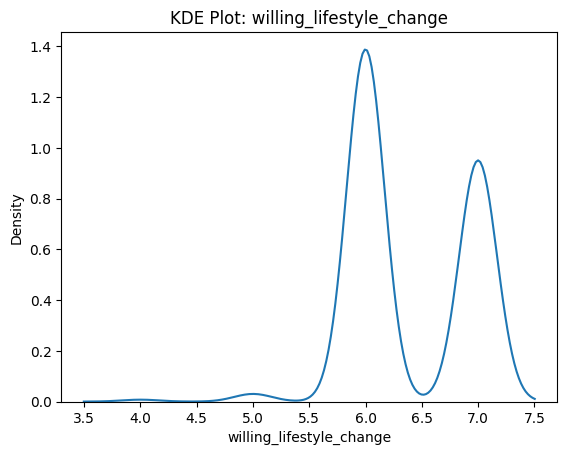

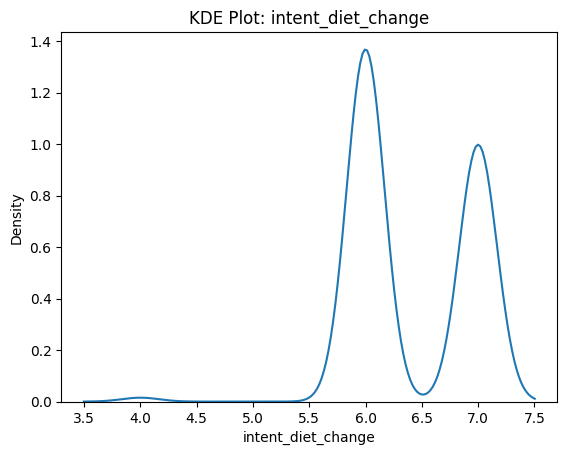

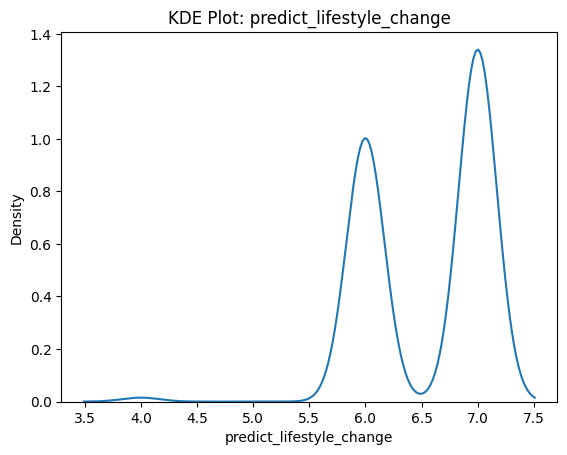

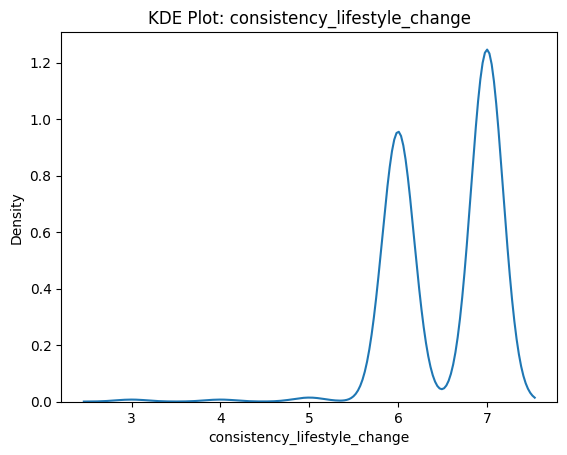

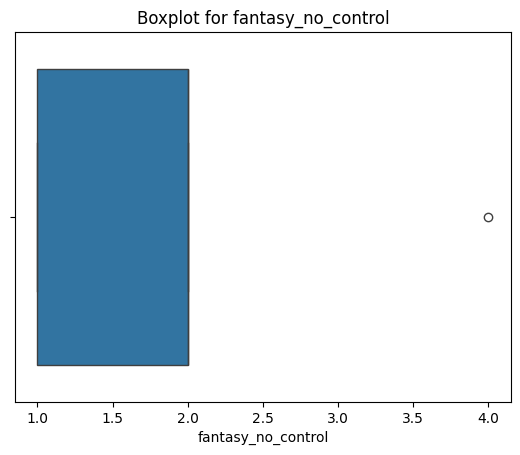

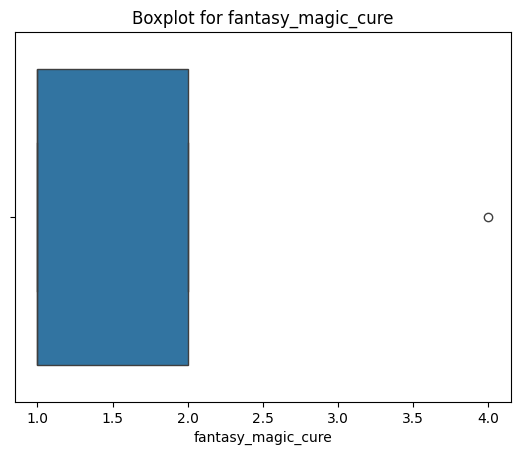

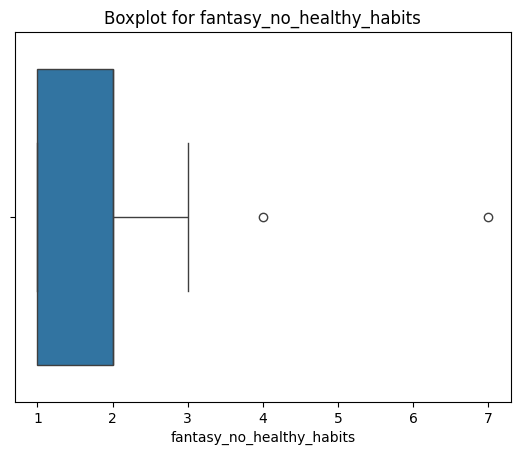

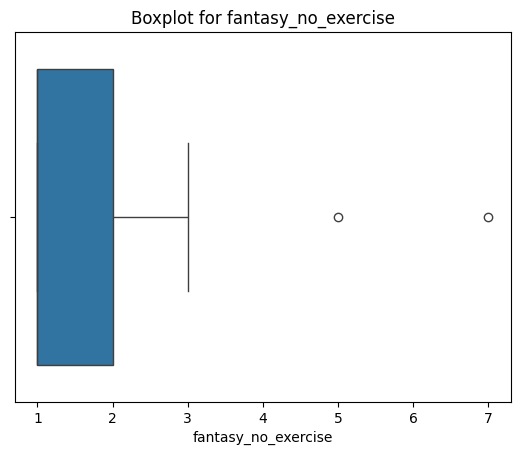

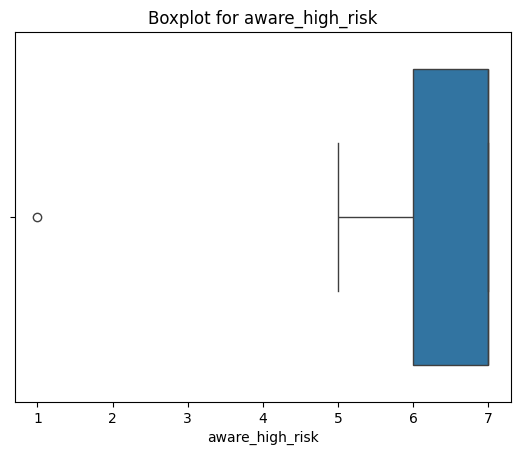

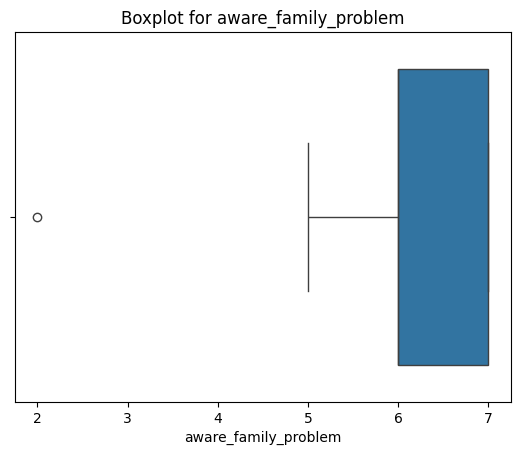

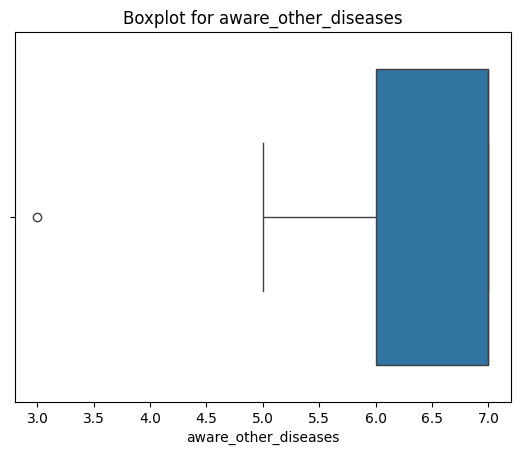

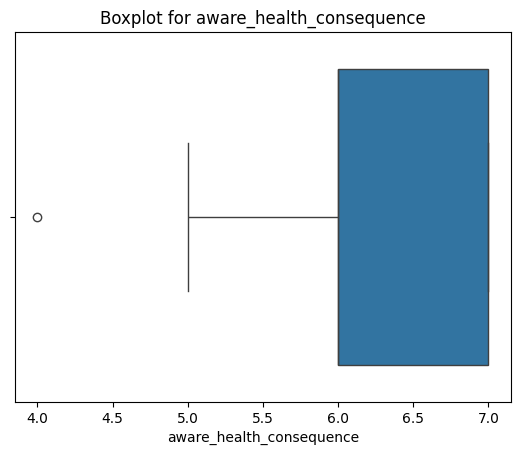

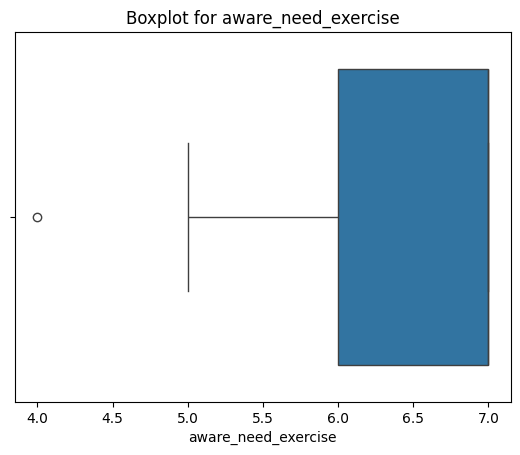

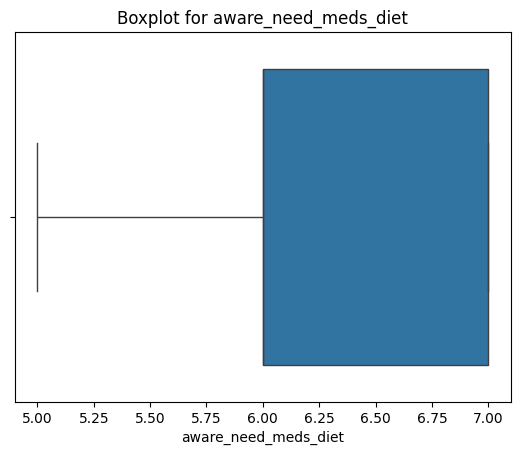

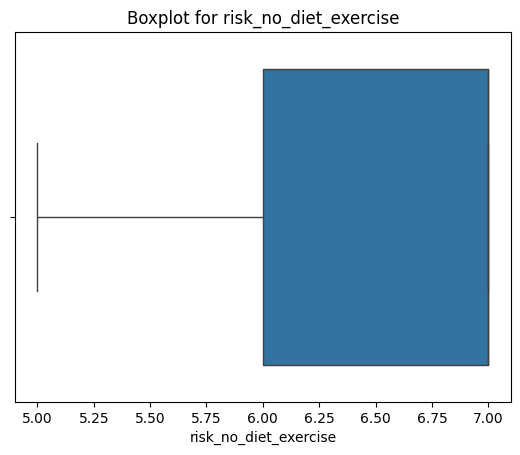

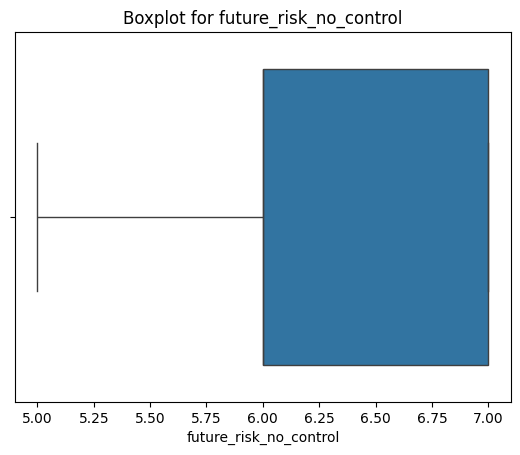

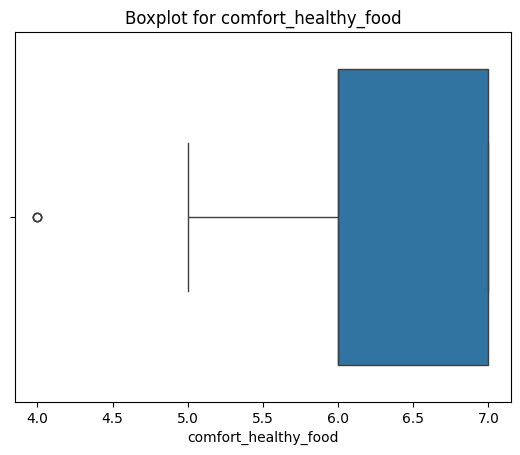

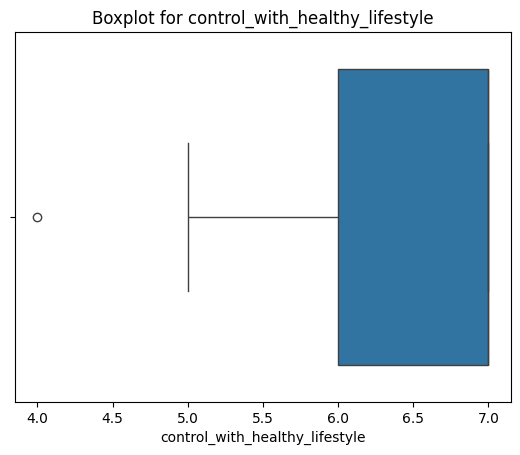

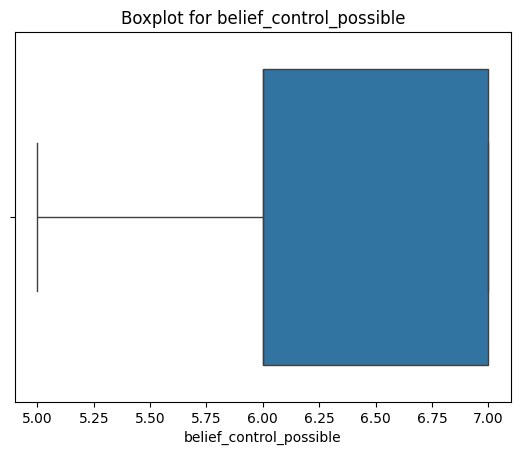

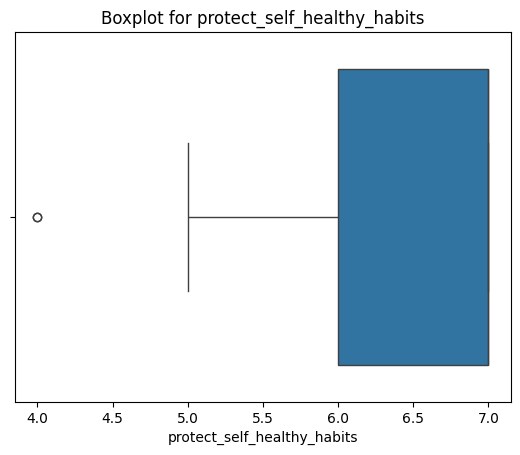

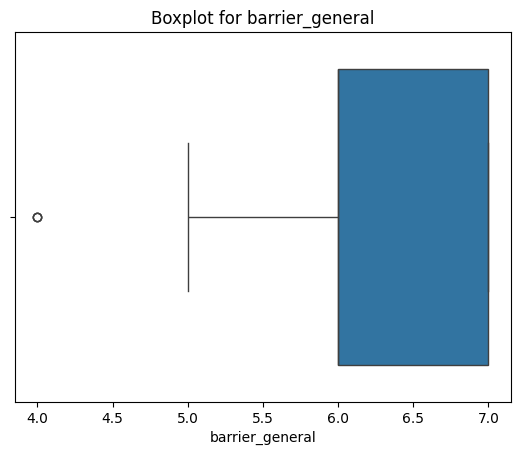

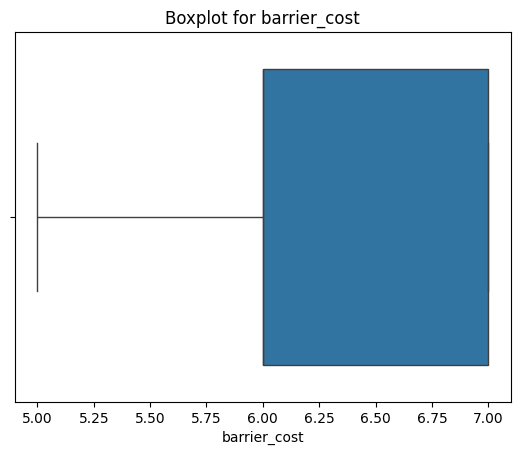

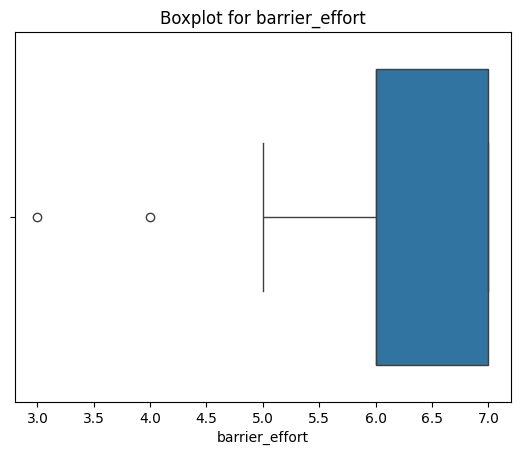

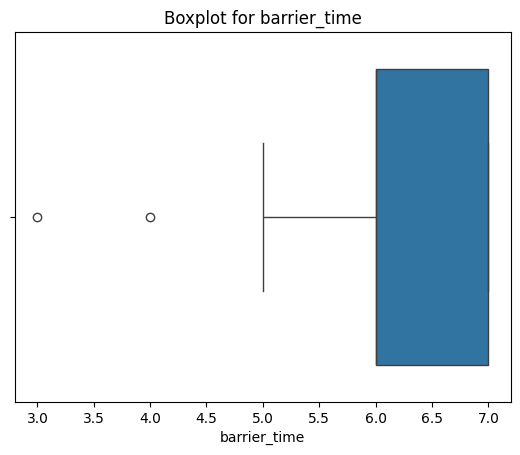

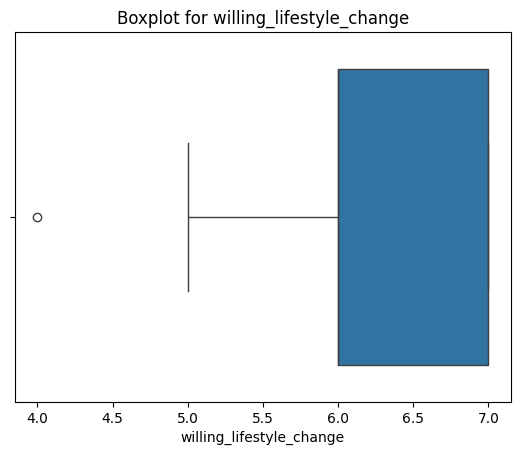

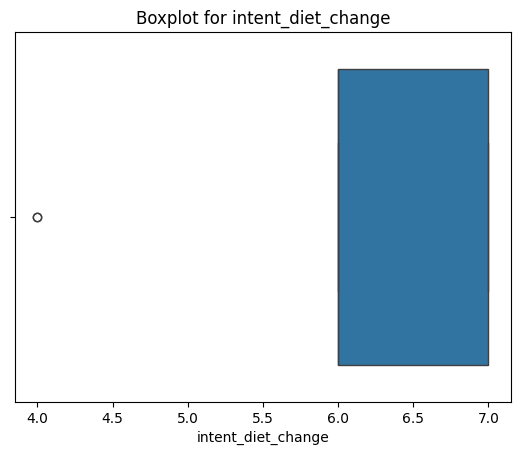

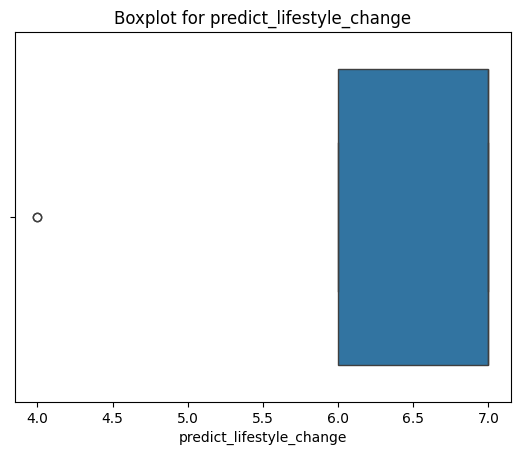

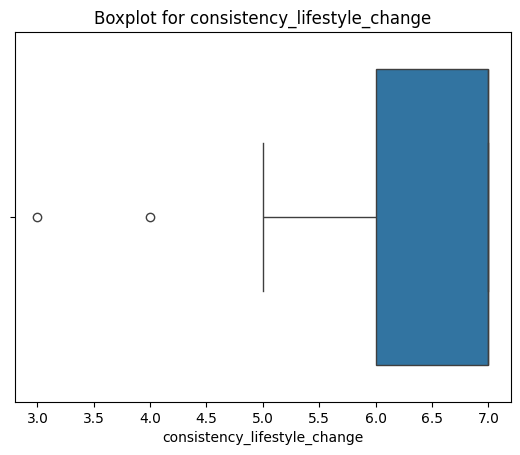

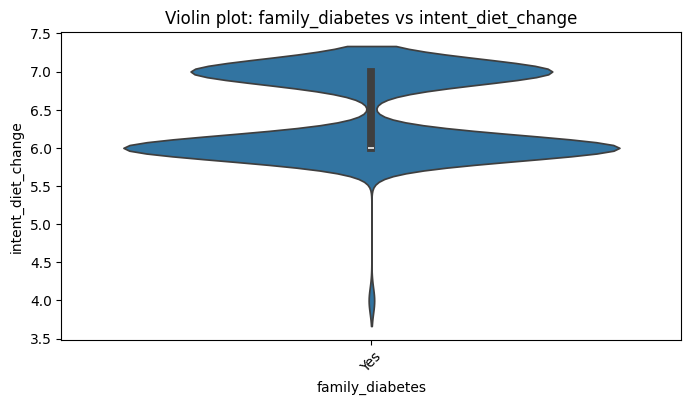

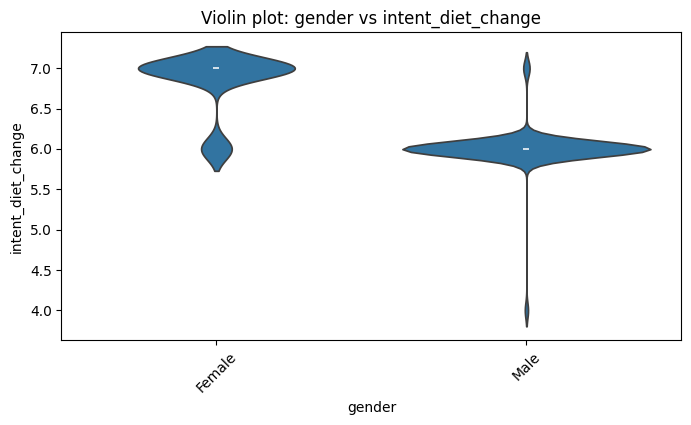

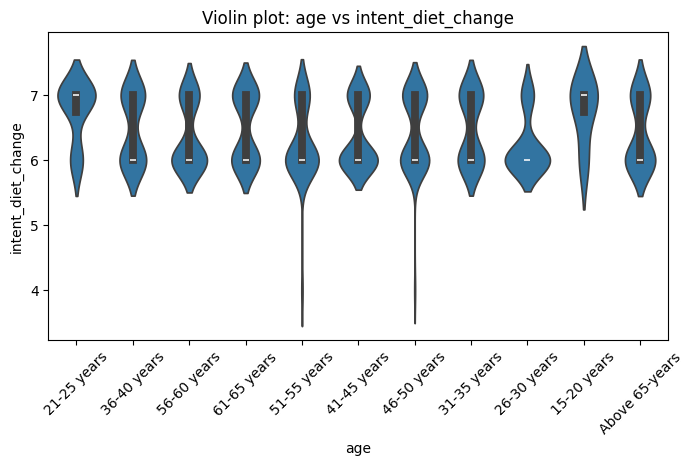

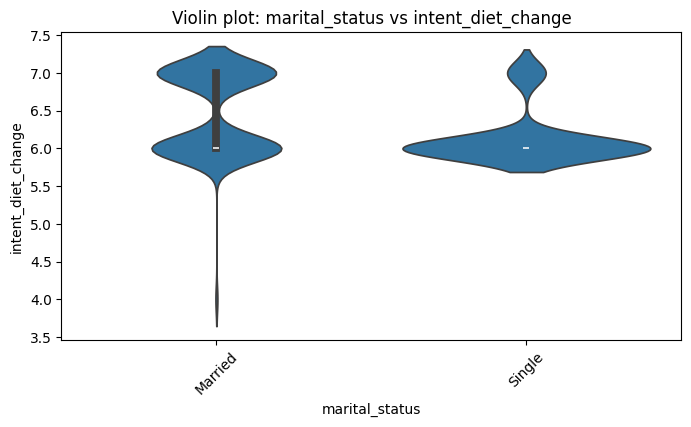

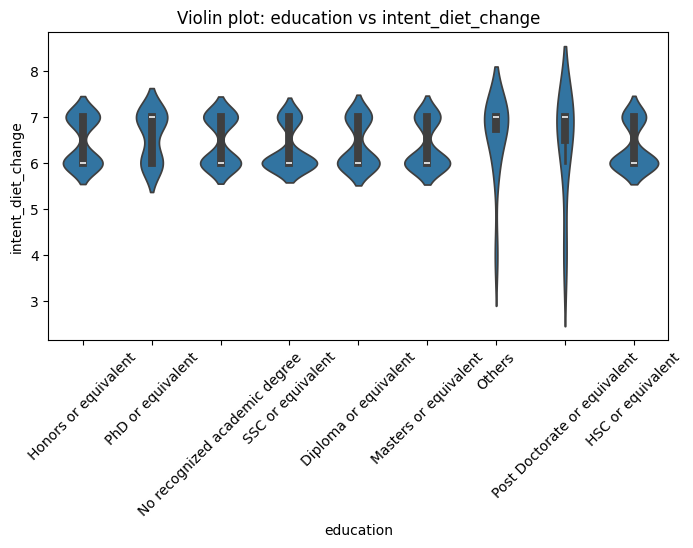

In [6]:
# 🔎 Step 5: Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution Plots
for col in num_cols:
    sns.kdeplot(df[col])
    plt.title(f"KDE Plot: {col}")
    plt.show()

# Boxplots for Outliers
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# Violin plots for selected categorical features
sample_cat = cat_cols[:5]
for col in sample_cat:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=df, x=col, y='intent_diet_change')
    plt.title(f"Violin plot: {col} vs intent_diet_change")
    plt.xticks(rotation=45)
    plt.show()

In [7]:
# 🎯 Step 6: Outlier Handling (Winsorization)
from scipy.stats.mstats import winsorize
for col in num_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])


In [8]:
# 🧠 Step 7: Encode Categorical Columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [9]:
# 📐 Step 8: Split Target and Features
X = df.drop(columns=['intent_diet_change'])
y = df['intent_diet_change']

In [10]:
# ⚖️ Step 9: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [11]:
# ➕ Step 10: Data Augmentation (20x)
augmented = [X_res + np.random.normal(0, 0.01, X_res.shape) for _ in range(19)]
X_aug = pd.concat([pd.DataFrame(X_res)] + [pd.DataFrame(x) for x in augmented], ignore_index=True)
y_aug = pd.concat([pd.Series(y_res)] * 20, ignore_index=True)


In [12]:
# 🔁 Step 11: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_aug)

In [13]:
# 📊 Step 12: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_aug, test_size=0.2, random_state=42)


In [14]:
# 🤖 Step 13: Define Models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "SVR": SVR(),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42, verbosity=0)
}

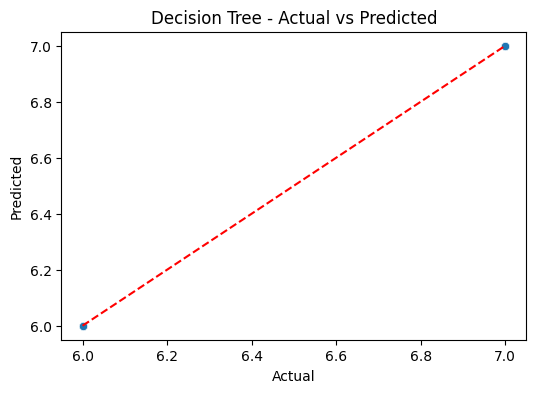

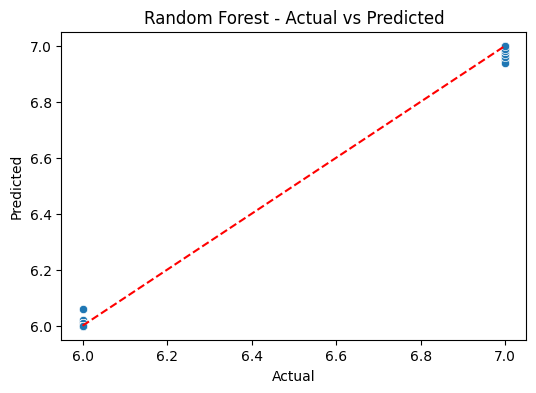

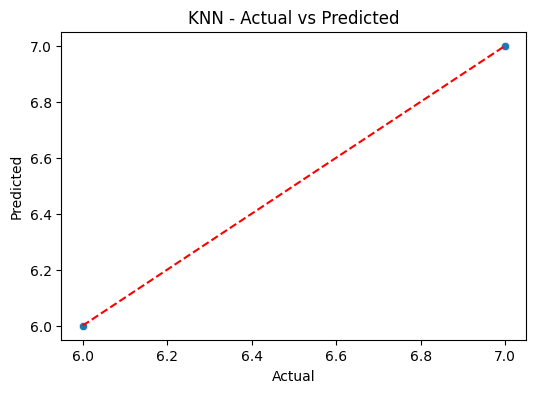

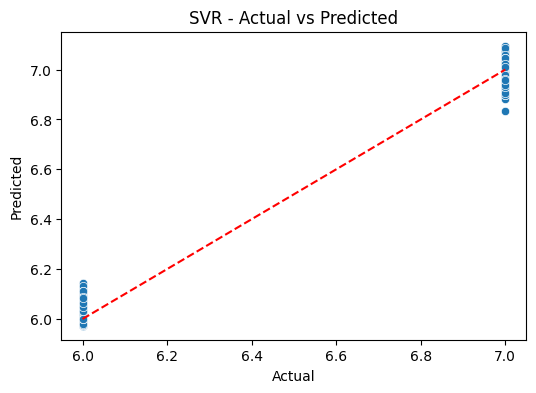

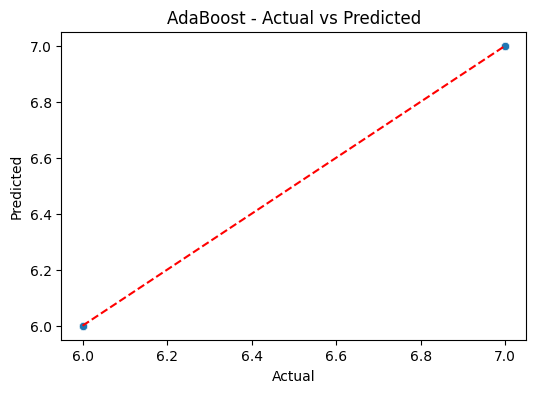

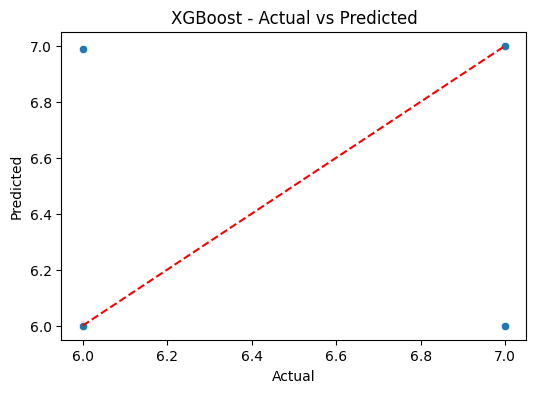


Model Performance Summary:
                    MAE       MSE      RMSE        R2      MAPE  CV_R2_Mean
Decision Tree  0.000000  0.000000  0.000000  1.000000  0.000000    1.000000
KNN            0.000000  0.000000  0.000000  1.000000  0.000000    1.000000
AdaBoost       0.000000  0.000000  0.000000  1.000000  0.000000    0.998632
Random Forest  0.000335  0.000012  0.003536  0.999950  0.000050    0.999746
XGBoost        0.001374  0.001352  0.036764  0.994582  0.000213    0.996479
SVR            0.036409  0.001968  0.044363  0.992111  0.005665    0.991729


In [15]:
# 📈 Step 14: Cross-Validation, Training, Evaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "CV_R2_Mean": scores.mean()
    }

    # Visualize prediction vs actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.show()

results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df.sort_values(by="R2", ascending=False))

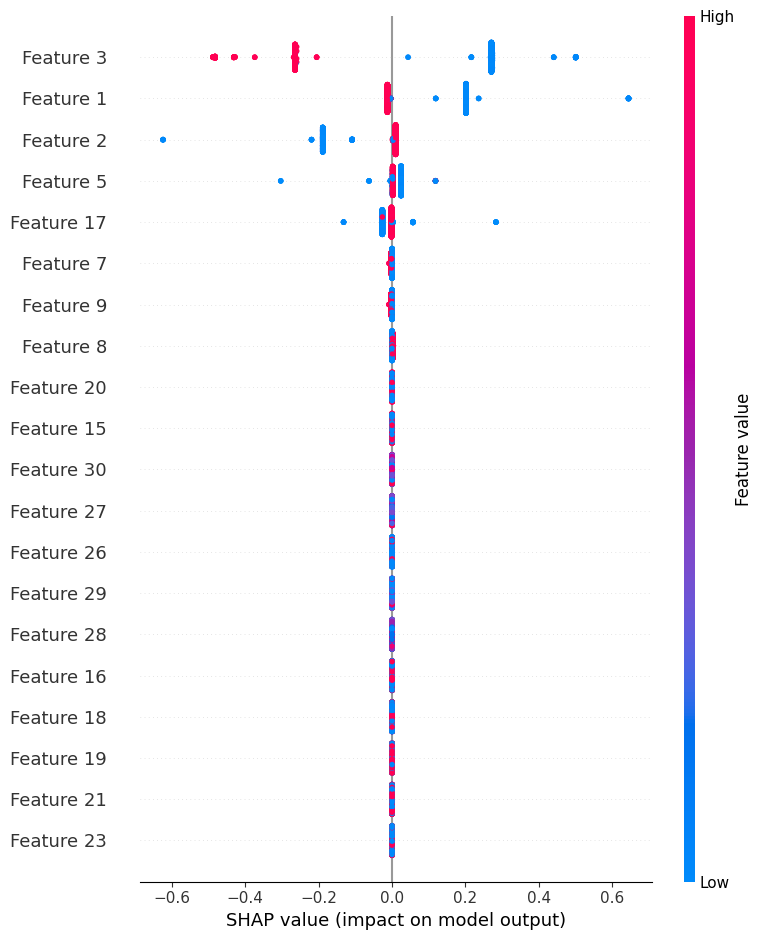

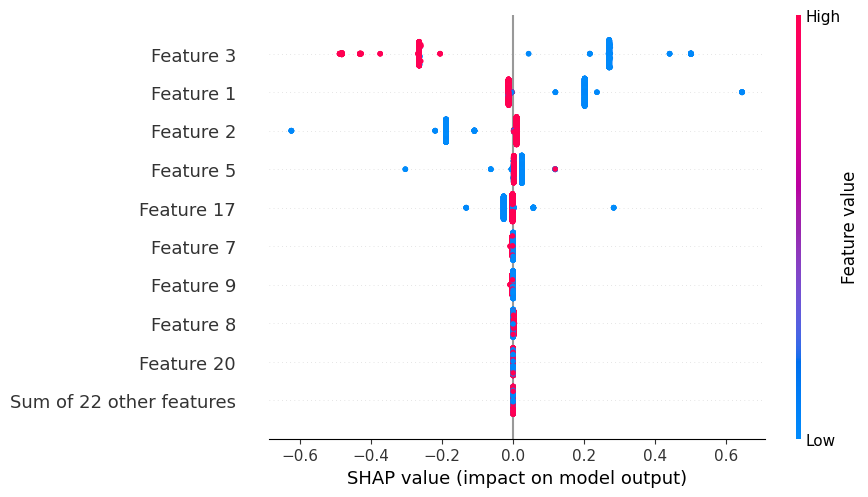

In [16]:
# 🔍 Step 15: Explainable AI - SHAP (XGBoost)
best_model = models['XGBoost']
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.plots.beeswarm(shap_values)


In [17]:
# 🔧 Step 16: Hyperparameter Tuning (RandomForest Example)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("\nBest Parameters (Random Forest):", grid_search.best_params_)
print("Best Cross-Validated R2:", grid_search.best_score_)



Best Parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validated R2: 0.9997535081286136


In [18]:
# 🕒 Step 17: Runtime Summary
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time):.2f} seconds")

# ✅ Project Extensions:
# - Add MLflow/Weights & Biases for experiment tracking
# - Try CatBoost and LightGBM models
# - Use SHAP dependence and interaction plots
# - Build dashboard with Streamlit/Gradio
# - Integrate prediction into web application
# - Apply PCA/feature selection techniques for optimization
# - Use LIME or ELI5 for model interpretation
# - Compare boosting strategies: CatBoost vs LightGBM vs XGBoost


Total execution time: 1749.95 seconds
